# V.1 Exploring the green reds

a) function to plot a scatterplot matrix of given data

In [4]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    red_wine = pd.read_csv(wine_data, sep=';')
    numvars, numdata = red_wine.shape
    fig = plt.figure()
    fig, axes = plt.subplots(numdata, numdata, figsize=(100, 100))
    for i in range(numdata):
        for j in range(numdata):
            if (i == j):
                axes[i, j].text(0.5, 0.5, red_wine.columns[i], fontsize=40, ha='center')
            else:
                colors = ['blue' if k >= good_threshold else 'red' for k in red_wine['quality']]
                size = [20 if k >= good_threshold else 20 if k <= bad_threshold else 0 for k in red_wine['quality']]
                axes[i, j].scatter(red_wine[red_wine.columns[i]], red_wine[red_wine.columns[j]], c=colors, s=size)
    plt.tight_layout()
    if (save_plot == True):
        plt.savefig('figure.png')
    else:
        fig

In [6]:
plot_scatter_matrix('winequality-red.csv', 6, 5, )

<Figure size 432x288 with 0 Axes>

b) which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines? Why?

A: Alcohol will be most useful data to distinguish high quality versus low quality wines. When looking at each data vs quality graph, alcohol is the only data that has a correlation with the quality. Most wine with quality 8 has alcohol percentage that is between 10 and 14 while wine with quality 3 has alcohol percentage between 8 and 11. Also, level of sulphateis also correlated to quality, but just not as strong as alcohol.

# V.2 Learning to perceptron
a) Implement a perceptron that:
    1) Has randomly initialized weights and bias
    2) Uses the Rosenblatt perceptron learning rule (with changeable learning rate)
    3) Utilizes the heaviside step activation function (discrete version)
    
b) Implelment a function to train perceptron:
    1) Specify number of training epochs (n_iter)
    2) If n_iter == 0, run until it makes no errors
    3) Specify learning rate (eta)
    4) Return list of python tuples containing:
        [(current_epoch, num_errors_at_epoch_end, [array_of_weights], bias), ...]

In [6]:
import random

def heaviside_step_function(x, good):
    ret = [0] * len(x)
    j = 0
    for i in x:
        if (i >= good and i != 0):
            ret[j] = 1
        else:
            ret[j] = -1
        j += 1
    return (ret)

def infinity():
    i = 0
    while True:
        yield i
        i += 1

def dot_product(X, w):
    ret = 0
    for i in range(len(w)):
        ret += X[i] * w[i]
    return (ret)

In [97]:
class Perceptron():
    def __init__(self, thresholds=0.0, eta=0.01, n_iter=10):
        self.thresholds = thresholds
        self.eta = eta
        self.n_iter = n_iter
    
    def fit(self, X, y):
        # randomly initialized weights(w[1:]) and bias(w[0])
        random.seed(3003)
        self.w = [random.random()] * (1 + X.shape[1])
        ret = []
        
        # Rosenblatt perceptron learning rule (adjusting slope of line)
        for i in infinity() if self.n_iter == 0 else range(self.n_iter):
            tmp_errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w[1:] += update * xi
                self.w[0] += update
                tmp_errors += int(update != 0.0)
            tup = (i, tmp_errors, self.w[1:], self.w[0])
            ret.append(tup)
            if (tmp_errors == 0 and self.n_iter == 0):
                break
        
        return (ret)
    
    def net_input(self, X):
        return (dot_product(X, self.w[1:]) + self.w[0])
    
    def predict(self, X):
        return (1 if self.net_input(X) > self.thresholds else -1)

c) A function that will take the output of perceptron training function and red wine data and generatet wo plots in one figure
    1) First plot: plot the number of errors that perceptron made as a function of epoch
    2) Second plot: plot the decision boundary of perceptron and show 'good' and 'bad' wine data points on the final training epoch. Shade 'good' and 'bad' areas.
    3) If a negative epoch is given, plots shows the last epoch

In [34]:
def find_min_max(max_, data):
    ret = data[0]
    if max_ == 0:
        for val in data:
            if val < ret:
                ret = val
    else:
        for val in data:
            if val > ret:
                ret = val
    return (ret)

def plot_performance(performance, wine_data, good_thresh, bad_thresh, epoch=-1, save_plot=False):
    errors = []
    for t in performance:
        errors.append(t[1])
    if (epoch < 0):
        tup = performance[len(performance) - 1]
    else:
        tup = performance[epoch]
        
    y_min = find_min_max(0, wine_data[wine_data.columns[0]].values)
    y_max = find_min_max(1, wine_data[wine_data.columns[0]].values)    
    x_min = find_min_max(0, wine_data[wine_data.columns[1]].values)
    x_max = find_min_max(1, wine_data[wine_data.columns[1]].values)
    
    wine_data0 = wine_data[wine_data['quality'] < good_thresh]
    wine_data1 = wine_data[wine_data['quality'] >= good_thresh]
    
    y = [0] * 11
    x = [0] * 11
    
    slope = -(tup[3]/tup[2][0])/(tup[3]/tup[2][1])
    intercept = -tup[3]/tup[2][0]
    k = 0
    for i in range(11):
        x[i] = k + x_min
        y[i] = slope * x[i] + intercept
        k += (x_max - x_min) / 10

    fg = plt.figure(figsize=(15, 5))
    ax1 = fg.add_subplot(121)
    ax2 = fg.add_subplot(122)
    ax1.plot(range(0, performance[len(performance) - 1][0]), errors[1:])
    ax1.set_title("Errors as a function of epoch")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("classification errors")
    
    ax2.plot(x, y, label="Decision Boundary")
    ax2.axis([x_min, x_max, y_min, y_max])
    ax2.fill_between(x, y, y_min - 2, where=y>y_min - 2, facecolor='blue', alpha=.2)
    ax2.fill_between(x, y, y_max + 2, where=y<y_max + 2, facecolor='red', alpha=.2)
    ax2.scatter(wine_data0[wine_data0.columns[1]], wine_data0[wine_data0.columns[0]], c='red', label='bad wines(<{0} score)'.format(bad_thresh + 1), s=20)
    ax2.scatter(wine_data1[wine_data1.columns[1]], wine_data1[wine_data1.columns[0]], c='blue', label='good wines(>{0} score)'.format(good_thresh -1), s=20)
    ax2.set_title("Decision boundary on epoch: {0}".format(tup[0]))
    ax2.set_xlabel(wine_data.columns[1])
    ax2.set_ylabel(wine_data.columns[0])
    ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.tight_layout()
    if (save_plot == True):
        plt.savefig('plot_performance.png')
    else:
        plt.show()

d) Using plot_performance function to plot and verify that perceptron learn more efficiently when data is modified

    Feature Scaling

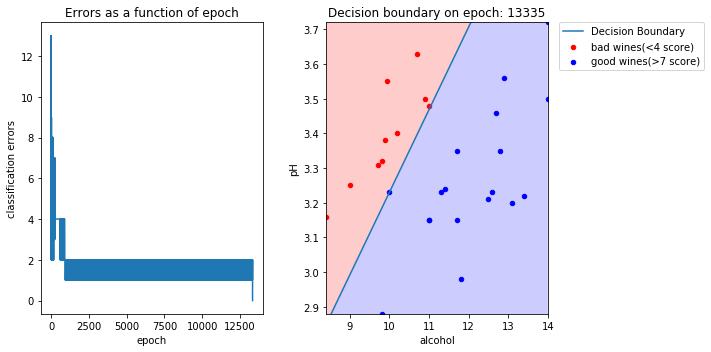

In [98]:
def before():
    df = pd.read_csv('winequality-red.csv', sep=';')
    df = df[(df.quality >= 8) | (df.quality <= 3)]
    y = df['quality'].values
    y = heaviside_step_function(y, 8)
    X = df[['pH', 'alcohol']].values

    # made as class to make it easier to modify, eta: learning rate; n_iter: training epochs
    ppn1 = Perceptron(eta=0.1, n_iter = 0)
    ret = ppn1.fit(X, y)
    plot_performance(ret, df[['pH', 'alcohol', 'quality']], 8, 3, )
    
before()

In [215]:
def mean(numbers):
    return (sum(numbers) / len(numbers))

def after():
    df = pd.read_csv('winequality-red.csv', sep=';')
    df = df[(df.quality >= 7) | (df.quality <= 4)]
    y = df['quality'].values
    y = heaviside_step_function(y, 7)
    X = df[['pH', 'alcohol']].values

    X0_min = find_min_max(0, df['pH'].values)
    X1_min = find_min_max(0, df['alcohol'].values)
    X0_max = find_min_max(1, df['pH'].values)
    X1_max = find_min_max(1, df['alcohol'].values)
    X0_mean = mean(df['pH'].values)
    X1_mean = mean(df['alcohol'].values)

    tmp = df[['pH', 'alcohol', 'quality']]
    
    for i in range(len(X)):
        X[i][0] = (X[i][0] - X0_mean) / (X0_max - X0_min)
        X[i][1] = (X[i][1] - X1_mean) / (X1_max - X1_min)
        tmp['pH'].values[i] = X[i][0]
        tmp['alcohol'].values[i] = X[i][1]

    # made as class to make it easier to modify, eta: learning rate; n_iter: training epochs
    ppn1 = Perceptron(n_iter = 0)
    ret = ppn1.fit(X, y)
    
    plot_performance(ret, tmp[['pH', 'alcohol', 'quality']], 7, 4, )

In [ ]:
after()

# V.3 My fair ADALINE

Use perceptron to distinguish between wines with a score of 4 an lower, and wines with a score of 7 and higher

a) Trying to let the perceptron train until it can find the best decision boundary will fail. Why it won't work?
    Because single perceptron can only draw straight line boundary